In [145]:
from sklearn.datasets import fetch_openml #sklearn to download data
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()
#  Warning: since Scikit-Learn 0.24, fetch_openml() returns a Pandas 
#  DataFrame by default. To avoid this and keep the same code as in the book, 
#  we use as_frame=False.

#   dataset = fetch_openml (name=  'データセットの名前またはID' ) 
#   data = dataset.data  # 特徴量データ
#   target = dataset.target  # ターゲット変数データ
#   feature_names = dataset.feature_names  # 特徴量の名前
#   target_names = dataset.target_names  # ターゲット変数の名前

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [146]:
#   Datasets loaded by Scikit-Learn generally have a similar dictionary structure,
#  including the following:
#  A DESCR key describing the dataset
#  A data key containing an array with one row per instance and one
#  column per feature
#  A target key containing an array with the labels

In [147]:
type(mnist)

sklearn.utils.Bunch

In [148]:
# look at these array
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)
print(type(X))
# 784 is because of these pics are 28*28

(70000, 784)
(70000,)
<class 'numpy.ndarray'>


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


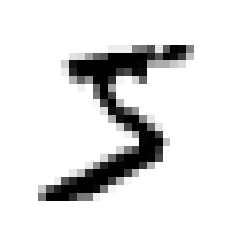

In [166]:
import matplotlib.pyplot as plt
import matplotlib as mpl

X = mnist['data']
print(type(X))
some_digit = X[0]
print(type(some_digit))
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

# reshape to 28 * 28 list

In [150]:
y[0]

'5'

In [151]:
# the label is string so we convert it to int
import numpy as np
y = y.astype(np.uint8)
print(y[0])

5


In [152]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000],y[60000:]
# mnist is already shuffled
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 =(y_test ==5)
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
#  The SGDClassifier relies on randomness during training (hence the name
#  “stochastic”). If you want reproducible results, you should set the 
#   random_state parameter.

sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [9]:
# one way for elvaluation
# from sklearn.model_selection import StratifiedKFold
# from sklearn.base import clone

# skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle =True)
# for train_index, test_index in skfolds.split(X_train, y_train_5):
#     clone_clf = clone(sgd_clf)
#     X_train_folds = X_train[train_index]
#     y_train_folds = y_train_5[train_index]
#     X_test_fold = X_train[test_index]
#     y_test_fold = y_train_5[test_index]
    
#     clone_clf.fit(X_train_folds, y_train_folds)
#     y_pred = clone_clf.predict(X_test_fold)
#     n_correct = sum(y_pred==y_test_fold)
#     print(n_correct/len(y_pred))
    

In [10]:
# try cross-validation
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [11]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

# found that accuracy is not a nice measure for classifiers

array([0.91125, 0.90855, 0.90915])

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# instead, this returns predictions made on each test fold
confusion_matrix(y_train_5, y_train_pred)
# 53892 correctly classified as non 5
# 687 wrongly classified as 5
# negative class

# 1891 wrongly classified as non 5
# 3530 were correctly classified as 5
# positive class

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [13]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [14]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) #  correct rate ( 3530/ (3530 + 687 ) )
# 83.71% to be correct when it claims a image to be representing 5

0.8370879772350012

In [15]:
recall_score(y_train_5, y_train_pred) #  correct rate ( 3530/ (3530 +1981 ) )
# 65.1%   5 to be  detected 

0.6511713705958311

In [16]:
# a harmonic mean of the two rate is F1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)
# precision/recall trade-off  
# which means to choose to have a high recall score or precision score on 
# different cases

0.7325171197343846

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [18]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [19]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
# raising the threshold decreases recall

array([False])

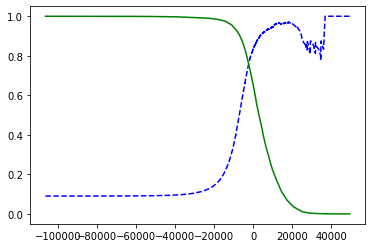

In [20]:
# to confirm which number to use for threshold
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

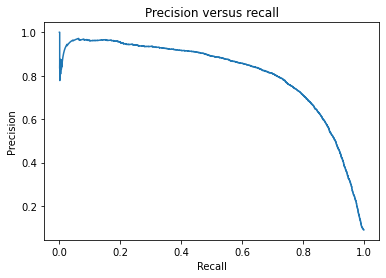

In [21]:
# another way to selec precision/recall trade-off
fig, ax = plt.subplots()
ax.set_xlabel("Recall")

# y 軸のラベルを設定する。
ax.set_ylabel("Precision")

# タイトルを設定する。
ax.set_title("Precision versus recall")
ax.plot(recalls, precisions)

In [22]:
# choose an aimed precision 
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
print(threshold_90_precision)
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)
recall_score(y_train_5, y_train_pred_90)

3370.0194991439557


0.4799852425751706

In [23]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

#   The FPR is the ratio of negative instances that are incorrectly 
#   classified as positive

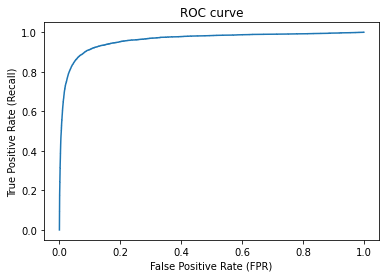

In [24]:
fig, ax = plt.subplots()
ax.set_xlabel("False Positive Rate (FPR)")

# y 軸のラベルを設定する。
ax.set_ylabel("True Positive Rate (Recall)")

# タイトルを設定する。
ax.set_title("ROC curve")
ax.plot(fpr, tpr)

In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores) 
# nice model gives a number close to 1 while bad ones give 0.5

0.9604938554008616

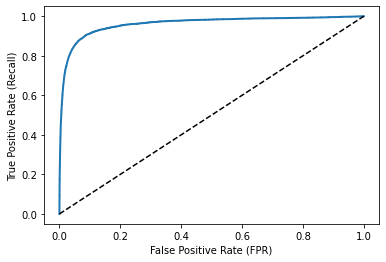

In [26]:
def plot_roc_curve(fpr, tpr ,label=None):
    plt.plot(fpr , tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--') #Dashed diagonal
    plt.xlabel ('False Positive Rate (FPR)')
    plt.ylabel ("True Positive Rate (Recall)")
    [...]
plot_roc_curve(fpr, tpr)
plt.show()

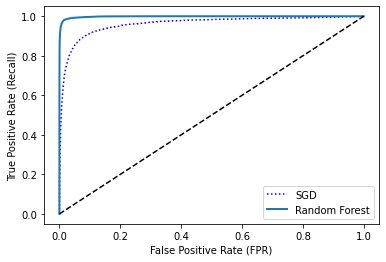

In [27]:
# train a RandomForestClassifier to compare
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method ="predict_proba")
y_scores_forest = y_probas_forest[:, 1] #score = proba of positive class
                                    # [:, 1] は全ての行の列値が１の値をarrayとして返す
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()
# Random Forest is definitely better

In [28]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [29]:
# measure the precision and recall scores
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))
print(f1_score(y_train_5, y_train_pred_forest))

# found that almost all scores are also better

0.9905083315756169
0.8662608374838591
0.9242275142688446


In [30]:
# (text P146)
# use Scikit-learn library to choose between OvR or OvO to train the classifier we need
from sklearn.svm import SVC
svm_clf =SVC()
svm_clf.fit(X_train, y_train) #y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [31]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores
# decision_function returns 10 scores per instance

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [32]:
print(np.argmax(some_digit_scores))
print(svm_clf.classes_[5])
svm_clf.classes_
#  When a classifier is trained, it stores the list of target classes in its classes_
#  attribute, ordered by value. In this case, the index of each class in the classes_
#  array conveniently matches the class itself (e.g., the class at index 5 happens to be
#  class 5), but in general you won’t be so lucky.


5
5


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [33]:
# to for the Scikit-Learn to use OvR or OvO
from sklearn.multiclass import OneVsRestClassifier #OvR forced
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])


array([5], dtype=uint8)

In [34]:
len(ovr_clf.estimators_)

10

In [35]:
# train a model with SGD or RandomForest
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [36]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [37]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
# quite a good score for all classifiers

array([0.87365, 0.85835, 0.8689 ])

In [38]:
#lift up the accuracy by scaling the inputs
# データをStandardScaler で標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [39]:
# Error Analysis
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

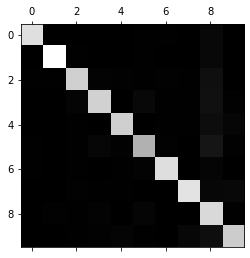

In [40]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()
# most images are on the main diagonal

In [41]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
row_sums #列ごとの和を取る

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]], dtype=int64)

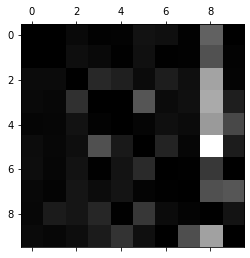

In [42]:
norm_conf_mx = conf_mx / row_sums #列ごとの割合をとる
# fill the diagonal with zeros to keep only the erros
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()
# a lot are misclassified as 8 (column)
# while actual 8 get properly classified as 8 (row)
# 3 and 5 are both confused a lot with each other (3,5),(5,3) are both quite bright


In [43]:
# EXTRA
def plot_digits(instances, images_per_row, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

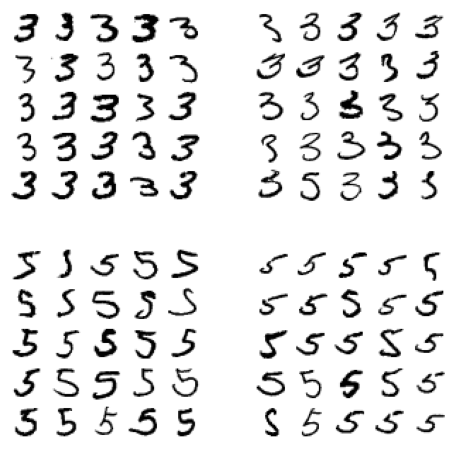

In [44]:
# analyzing individual errors
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()
#  plt.subplot(221)は、行数2、列数2のサブプロットのうち、
#  1番目のサブプロットを指定しています。行数と列数はそれぞれ2であるため、
#  合計で4つのサブプロットがあります。
# 3 and 5 differs just by a little number of pixels so SGDClassifier doesnt work well

In [45]:
# make a multilabel classification

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd=(y_train %2 ==1) #奇数を取り出す
y_multilabel = np.c_[y_train_large, y_train_odd] #np.c_は異なる次元の配列を結合する関数

knn_clf =KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [46]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [47]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average = 'weighted')

0.9778357403921755

In [48]:
len(X_train)

60000

In [49]:
# add some noise to the pixels
noise = np.random.randint(0 ,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test
#  numpy.random.randint(low, high=None, size=None, dtype=int)

#  low（必須）: 生成される整数の最小値（含む）。

#   high（オプション）: 生成される整数の最大値（排他的）。highは省略可能で、
#   省略された場合はlow以上の範囲でランダムな整数が生成されます。

#   size（オプション）: 生成するランダムな整数の形状を指定するタプルまたは整数。
#   例えば、size=(3, 2)とすると3行2列の2次元配列が生成されます。sizeは省略可能で、
#   単一の整数を指定すると1次元の配列が生成されます。

#   dtype（オプション）: 生成される整数のデータ型を指定します。デフォルトはintです。

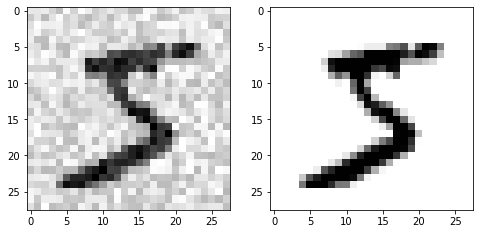

In [50]:
plt.figure(figsize=(8,8))
some_index = 0
plt.subplot(121); plt.imshow(X_train_mod[0].reshape(28, 28), cmap="binary")
plt.subplot(122); plt.imshow(X_train[0].reshape(28, 28), cmap="binary")
plt.show()


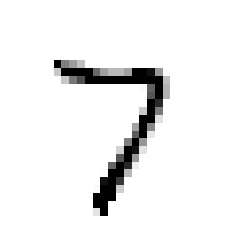

In [74]:
knn_clf.fit(X_train_mod, y_train_mod) # y_train_mod = X_train so that the 
                                      # prediction outputs cleaned pic
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digits(clean_digit, images_per_row=1)

In [ ]:
y_knn_pred = knn_clf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

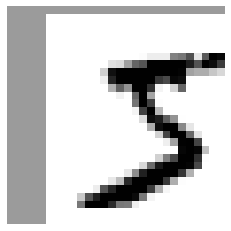

In [62]:
from scipy.ndimage.interpolation import shift
#  shift関数をインポートしています。
#  この関数は、画像のシフト操作を行うために使用されます。


def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

#  shift_digitという関数が定義されています。この関数は、
#  digit_arrayという入力画像データを受け取り、指定したdxとdyの値に基づいて画像をシフトします。

# digit_arrayは28x28の形状を持つ画像データであり、reshape(28, 28)によってこの形状に変形されます。
# shift関数は、変形された画像データと[dy, dx]の値を受け取り、指定した方向に画像をシフトします。
# cval=newは、シフトされた画像の空いた領域を指定した新しい値newで埋めるためのパラメータです。

shifted_digit = [shift_digit(some_digit, 5, 1, new=100)]
plot_digits(shifted_digit, images_per_row=1)
# some_digitのサンプルを出力する、dy=1, dx=5なので右５　下１


In [97]:
shifted_k = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=1, dy=1)
shifted_k.shape

(60000, 784)

In [104]:
#  train a shifted list
X_train_expanded = [X_train]
y_train_expanded = [y_train]
#  2つのリストを作成し、それぞれ最初の要素としてX_trainとy_trainを格納しています。
#  これは、元のデータセットを拡張したデータを格納するためのリストです。

#  最初の反復: dx = 1, dy = 0
#  2番目の反復: dx = -1, dy = 0
#  3番目の反復: dx = 0, dy = 1
#  4番目の反復: dx = 0, dy = -1

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)
# つの方向に対してシフト操作を行います。
# dxとdyはそれぞれx方向とy方向のシフト量を表す変数です。

 # print(len(X_train_expanded))   dx, dxそれぞれに対して2回、+最初の１　＝５
    
#  numpy.apply_along_axis()関数は、
#  指定した軸に沿って関数を適用するための便利な機能を提供します。この関数は、
#  NumPyの多次元配列に対して要素ごとの操作を行う際に使用されます。
# numpy.apply_along_axis(func1d, axis, arr, *args, **kwargs)
# arr: 処理を行う多次元配列。
print(len(X_train_expanded[1][1]))
X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)


#  X_train_expandedとy_train_expandedのリスト内の配列を結合し、
#  1つの大きな配列にします。これにより、拡張されたデータセットが作成されます。


784


In [99]:
X_train_expanded.shape

(300000, 784)

In [80]:
y_train_expanded.shape

(300000,)

In [106]:
X_train_expanded[0].shape

(784,)

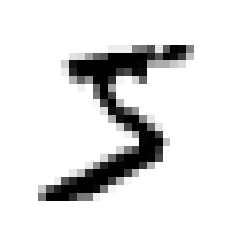

In [107]:
plot_digits([X_train_expanded[0]], images_per_row=1)

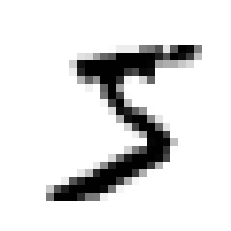

In [108]:
plot_digits([X_train_expanded[60000]], images_per_row=1)

In [92]:
a = [1,3,4]
b = [3, 5, 6]
k = np.concatenate((a,b))
k

array([1, 3, 4, 3, 5, 6])

In [109]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier()

In [110]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [111]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_expanded_pred)

0.9754

In [120]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])
# predict_proba、機械学習モデルによる予測結果の確率を返すメソッドです。
# このメソッドは、分類タスクにおいて各クラスに属する確率を予測する際に使用されます。
#  各クラスに属する確率を返します
print(len(knn_clf.predict_proba([ambiguous_digit])[0]))

10


In [116]:
knn_clf.predict_proba([ambiguous_digit])

array([[0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.8]])

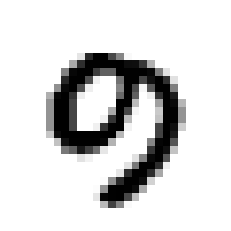

In [126]:
plot_digits([ambiguous_digit],images_per_row=1)
# 80% to be 9

In [154]:
type(X_train)

numpy.ndarray

<class 'numpy.ndarray'>


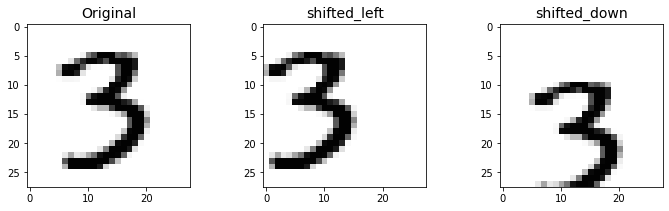

In [170]:
# Data Augmentation

from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy, new=0):
    shifted_image = shift(image.reshape(28, 28), [dy, dx], cval=new, mode="constant")
    return shifted_image.reshape([-1]) #配列を一次元へ戻す
image = X_train[10000]
image_left = shift_image(image,-5, 0)
image_down = shift_image(image, 0 , 5 )

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("shifted_left", fontsize=14)
plt.imshow(image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("shifted_down", fontsize=14)
plt.imshow(image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")

print(type(image_left))

In [158]:
type(X_train)

numpy.ndarray

In [178]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]
print(type(X_train_augmented))
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

<class 'list'>


In [177]:
# X_train_augmented =X_train.copy()  # listに変換する,appendを使うために
# y_train_augmented = y_train.copy() #np.appendを使うと凄く時間がかかる

# for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
   #  for image, label in zip(X_train, y_train):
     #    X_train_augmented= np.append(X_train_augmented, shift_image(image, dx, dy))
     #    y_train_augmented= np.append(y_train_augmented, label)



In [135]:
#  データセットをシャッフルするための処理です。シャッフルは、
#  トレーニングデータセットの順序をランダムに入れ替えることで、
#  モデルのトレーニングや評価のバイアスを減らすために使用されます。
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]
#同じshuffle_idxを使うとおなじshuffleになる

60000

In [180]:
# モデルの性能を最適化するために、ユーザーが事前に指定するパラメータ
#（ハイパーパラメータ）の最適な値を探索するプロセスを指定するために
# **grid_search.best_params_を使った、使用しなくても良いが点数が少し落ちる
# 使用する凄く時間がかかる
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9754

In [136]:
X_train = [1, 2, 3, 4, 5]
y_train = ['A', 'B', 'C', 'D', 'E']

zipped = zip(X_train, y_train)

for item in zipped:
    print(item)


(1, 'A')
(2, 'B')
(3, 'C')
(4, 'D')
(5, 'E')
